In [1]:
%pip install --upgrade -q pip

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install -q huggingface_hub open_clip_torch

Note: you may need to restart the kernel to use updated packages.


---

In [107]:
from os.path import join
from glob import glob
import gc
from IPython import display

from rastervision.pipeline.file_system.utils import (
    file_exists, file_to_json, json_to_file, list_paths)
from rastervision.core.box import Box
from rastervision.core.data import (
    geoms_to_geojson, RasterioSource, RasterioCRSTransformer, Scene)
from rastervision.core.data.raster_source.stac_config import subset_assets
from rastervision.pytorch_learner.dataset import (
    SemanticSegmentationSlidingWindowGeoDataset)

from tqdm.auto import tqdm
import albumentations as A
import numpy as np
import bisect
import torch
from torch.utils.data import ConcatDataset, DataLoader
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.reset_defaults()

import pystac_client
from pystac import ItemCollection
from shapely.geometry import mapping, shape
import geopandas as gpd
import rasterio as rio

<Axes: >

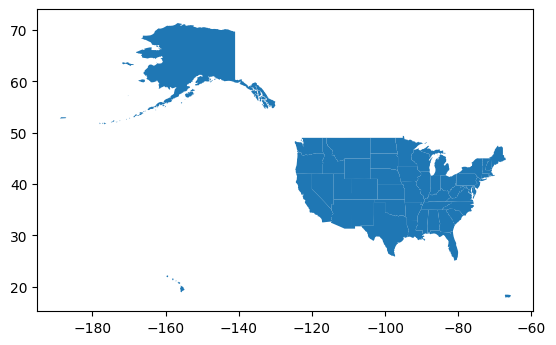

In [3]:
import geopandas as gpd
df = gpd.read_file('us-states.json')
df.plot()

In [52]:
import pystac_client
from shapely.geometry import mapping

df_aoi = df[df.name == 'Pennsylvania']
aoi = df_aoi.geometry.unary_union.simplify(0)
catalog = pystac_client.Client.open('https://earth-search.aws.element84.com/v1')
items = catalog.search(
    intersects=mapping(aoi),
    collections=['sentinel-2-l2a'],
    datetime='2023-06-01/2023-12-01',
    query={'eo:cloud_cover': {
        'lt': 5
    }},
).item_collection()
len(items)

180

In [236]:
items_df = gpd.GeoDataFrame.from_features(items)
items_df.loc[:, '_id'] = np.arange(len(items_df))
items_df = items_df[items_df.area > np.quantile(items_df.area, 0.5)]
len(items_df)

90

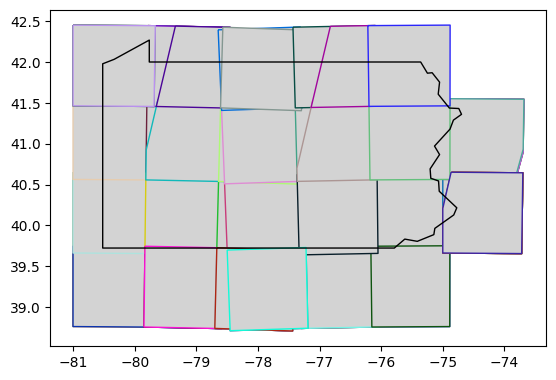

In [237]:
fig, ax = plt.subplots()
items_df.plot(ax=ax, ec=np.random.rand(len(items_df), 3), fc='lightgray', lw=1)
df_aoi.plot(ax=ax, ec='k', fc='none')
plt.show()

In [160]:
from rastervision.core.data import AoiSampler
from rastervision.core.data.utils import all_equal
from shapely.geometry import Point
import pandas as pd

In [133]:
aoi_sampler = AoiSampler(df_aoi.geometry)

In [239]:
def get_single_item_id_at_point(pt: 'Point'):
    matched_items_df = items_df[items_df.contains(pt)]
    if len(matched_items_df) == 1:
        return matched_items_df._id.item()
    if all_equal(df.area.to_list()):
        i = np.argmax(matched_items_df.datetime)
        return matched_items_df.iloc[i]._id.item()
    i = np.argmax(matched_items_df.area)
    return matched_items_df.iloc[i]._id.item()

pt = Point(-75.36776594,  40.19652437)
get_single_item_id_at_point(pt)

35

In [242]:
ids = set([get_single_item_id_at_point(Point(x, y)) for x, y in aoi_sampler.sample(n=1000)])
len(set(ids))

25

In [245]:
filtered_items_df = items_df[items_df._id.isin(ids)]

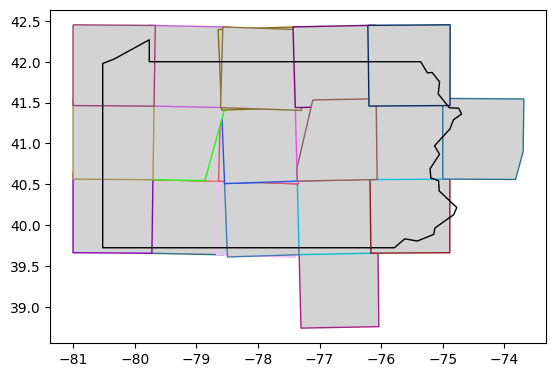

In [246]:
fig, ax = plt.subplots()
filtered_items_df.plot(ax=ax, ec=np.random.rand(len(filtered_items_df), 3), fc='lightgray', lw=1)
df_aoi.plot(ax=ax, ec='k', fc='none')
plt.show()

In [247]:
print("{%s}" % ', '.join(map(str, ids)))

{10, 11, 140, 12, 15, 143, 145, 16, 17, 144, 30, 34, 35, 38, 39, 168, 171, 51, 52, 53, 67, 75, 78, 97, 99}


In [248]:
items_filtered = [items[i] for i in ids]
len(items_filtered)

25

In [251]:
[item.id for item in items_filtered]

['S2B_17TPE_20231119_0_L2A',
 'S2B_17TQE_20231119_0_L2A',
 'S2B_18TUL_20230831_0_L2A',
 'S2B_18TTK_20231119_0_L2A',
 'S2B_17TPF_20231119_1_L2A',
 'S2B_18TTM_20230831_0_L2A',
 'S2B_18TUM_20230831_0_L2A',
 'S2B_17TQF_20231119_1_L2A',
 'S2B_18TTL_20231119_0_L2A',
 'S2B_17TQG_20230831_0_L2A',
 'S2B_18SUJ_20231116_0_L2A',
 'S2B_18TUK_20231116_0_L2A',
 'S2B_18TVK_20231116_0_L2A',
 'S2B_18TVL_20231116_0_L2A',
 'S2B_18TWL_20231116_0_L2A',
 'S2A_18TUL_20230604_0_L2A',
 'S2A_18TVM_20230604_0_L2A',
 'S2A_17TPF_20231114_0_L2A',
 'S2A_17TQF_20231114_0_L2A',
 'S2A_18TTL_20231114_0_L2A',
 'S2B_17TNE_20231102_0_L2A',
 'S2B_17TPF_20231023_0_L2A',
 'S2B_17TPG_20231023_0_L2A',
 'S2B_17TNF_20231003_0_L2A',
 'S2B_17TNG_20231003_0_L2A']

In [72]:
import stackstac

In [81]:
items[0].assets['red'].href

'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/15/S/UA/2024/2/S2B_15SUA_20240228_0_L2A/B04.tif'

In [78]:
stackstac.stack(items, assets=['red', 'green', 'blue'], epsg=32618)

<xarray.DataArray 'stackstac-671514fafd0e22c8bb657a882716a708' (time: 2878,
                                                                band: 3,
                                                                y: 399417,
                                                                x: 515143)>
dask.array<fetch_raster_window, shape=(2878, 3, 399417, 515143), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 2024-02-01...
    id                                       (time) <U24 'S2B_18SWJ_20240201_...
  * band                                     (band) <U5 'red' 'green' 'blue'
  * x                                        (x) float64 -3.962e+06 ... 1.19e+06
  * y                                        (y) float64 6.697e+06 ... 2.703e+06
    instruments                              <U3 'msi'
    ...                                       ...
    raster:bands                             object {'nodata': 0, 'data_type'...
    proj:shape                               object {10980}
    common_name                              (band) <U5 'red' 'green' 'blue'
    center_wavelength                        (band) float64 0.665 0.56 0.49
    full_width_half_max                      (band) float64 0.038 0.045 0.098
    epsg                                     int64 32618
Attributes:
    spec:        RasterSpec(epsg=32618, bounds=(-3961600.0, 2702970.0, 118983...
    crs:         epsg:32618
    transform:   | 10.00, 0.00,-3961600.00|\n| 0.00,-10.00, 6697140.00|\n| 0....
    resolution:  10.0

In [8]:
from rastervision.core.data import Scene, XarraySource
from rastervision.core.data.raster_source.stac_config import subset_assets

In [9]:
item = subset_assets(item, ['red', 'green', 'blue'])
rs_stats = XarraySource.from_stac(
    item,
    allow_streaming=False,
)
stats_tf = StatsTransformer.from_raster_sources([rs_stats])

2024-02-23 17:40:00:rastervision.core.data.raster_source.xarray_source: INFO - Loading the full DataArray into memory (2.9 GB).
INFO:rastervision.core.data.raster_source.xarray_source:Loading the full DataArray into memory (2.9 GB).


Analyzing chips: 0it [00:00, ?it/s]

In [10]:
rs = XarraySource(
    rs_stats.data_array,
    crs_transformer=rs_stats.crs_transformer,
    raster_transformers=[stats_tf],
    temporal=False
)
rs.shape

(10980, 10980, 3)

In [11]:
scene = Scene('', raster_source=rs)
ds = SemanticSegmentationSlidingWindowGeoDataset(
    scene,
    size=400,
    stride=400,
    padding=0,
    transform=A.Resize(224, 224),
)
dl = DataLoader(ds, batch_size=8)
len(ds)

729

---

In [ ]:
!git clone https://github.com/ChenDelong1999/RemoteCLIP/ --depth 1

In [1]:
from os.path import join

from huggingface_hub import hf_hub_download
import torch, open_clip

In [2]:
model_name = ['ViT-L-14']
# checkpoint_path = hf_hub_download('chendelong/RemoteCLIP', f'RemoteCLIP-{model_name}.pt', cache_dir='checkpoints')
# print(f'{model_name} is downloaded to {checkpoint_path}.')

In [3]:
model_name = 'ViT-L-14'
model, _, preprocess = open_clip.create_model_and_transforms(model_name)
tokenizer = open_clip.get_tokenizer(model_name)

print('#params: ', f'{sum(p.numel() for p in model.parameters()):,}')

#params:  427,616,513


In [4]:
checkpoints_dir = 'checkpoints/models--chendelong--RemoteCLIP/snapshots/bf1d8a3ccf2ddbf7c875705e46373bfe542bce38'
checkpoint_path = join(checkpoints_dir, f'RemoteCLIP-{model_name}.pt')
ckpt = torch.load(checkpoint_path)
message = model.load_state_dict(ckpt)
model = model.cuda().eval()

---

In [12]:
embs = []
with torch.inference_mode(), tqdm(dl, desc='Creating chip embeddings') as bar:
    for x, _ in bar:
        x = x.cuda()
        _emb_1 = model.encode_image(x)
        _emb_2 = model.encode_image(x.flip(2))
        _emb_3 = model.encode_image(x.flip(3))
        _emb_4 = model.encode_image(x.flip(2).flip(3))
        emb = sum([_emb_1, _emb_2, _emb_3, _emb_4]) / 4
        # emb = model.encode_image(x)
        embs.append(emb.cpu())
embs = torch.cat(embs, dim=0)
embs /= embs.norm(dim=-1, keepdim=True)
embs.shape

Creating chip embeddings:   0%|          | 0/92 [00:00<?, ?it/s]

torch.Size([729, 768])

In [13]:
torch.save(embs, 'RemoteCLIP_s2_embeddings_400_200.pt')

In [9]:
embs = torch.load('RemoteCLIP_s2_embeddings_400_200.pt')
embs.shape

torch.Size([729, 768])

In [14]:
model = model.cpu()
torch.cuda.empty_cache()

In [6]:
def show_top_chips(chip_scores, raster_source, windows, nrows=5, ncols=5, figsize=(12, 12), w_pad=-2.5, h_pad=-2.5):
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    fig.tight_layout(w_pad=w_pad, h_pad=h_pad)
    top_inds = torch.topk(chip_scores, axs.size).indices
    for ax, ind in zip(axs.flat, top_inds):
        chip = raster_source.get_chip(windows[ind])
        ax.imshow(chip)
        ax.axis('off')
    plt.show()

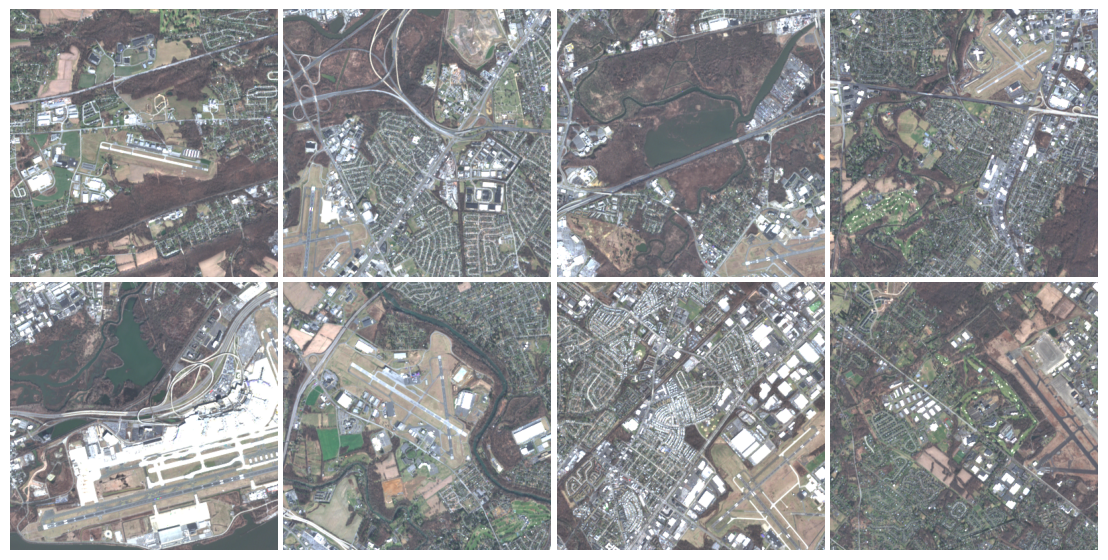

In [15]:
T = 0.01
text_queries = [
    # 'crop fields',
    # 'river',
    # 'barren land',
    # 'a bridge over a river',
    'airport',
    # 'stadium',
    # 'warehouses',
    # 'storage tanks',
    # 'power plant',
]
assert len(text_queries) == 1
text = tokenizer(text_queries)
with torch.inference_mode():
    text_features = model.encode_text(text)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_features = text_features.cpu()
    chip_scores = torch.cosine_similarity(text_features, embs)
    # chip_scores = (chip_scores / T).softmax(dim=0)
    # chip_scores = chip_scores / chip_scores.max()

# show_windows(img, ds.windows, chip_scores, figsize=(10, 10))
show_top_chips(chip_scores, rs, ds.windows, nrows=2, ncols=4, figsize=(12, 6), w_pad=-5.5, h_pad=-1.75)

In [ ]:
plt.hist(chip_scores, bins=30)
plt.show()

---

In [ ]:
from rastervision.pipeline.file_system.utils import json_to_file
from rastervision.core.data import ClassConfig, boxes_to_geojson

In [ ]:
geojson = boxes_to_geojson(ds.windows, [0] * len(ds), rs.crs_transformer, ClassConfig(names=['airport']), scores=chip_scores.tolist())

# json_to_file(geojson, 'RemoteCLIP_airport_detections.json')
# json_to_file(geojson, 'RemoteCLIP_stadium_detections.json')
# json_to_file(geojson, 'RemoteCLIP_bridge_detections.json')
# json_to_file(geojson, 'RemoteCLIP_warehouses_detections.json')
# json_to_file(geojson, 'RemoteCLIP_suburbs_detections.json')
# json_to_file(geojson, 'RemoteCLIP_factory_detections.json')
# json_to_file(geojson, 'RemoteCLIP_quarry_detections.json')

In [ ]:
from rastervision.core.data.utils import write_bbox

In [ ]:
geojson = boxes_to_geojson(
    ds.windows, [0] * len(ds), rs.crs_transformer, ClassConfig(names=text_queries), scores=chip_scores.tolist())

json_to_file(geojson, f'RemoteCLIP_naip_{text_queries[0]}.json')